In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

np.random.seed(42)
random.seed(42)

In [3]:
# Load and Explore Dataset

data_dir = "/kaggle/input/animal-dataset/animal_dataset"

CATEGORIES = []
for c in os.listdir(data_dir):
    CATEGORIES.append(c)

print("\nClasses:", CATEGORIES)
print("Total number of classes:", len(CATEGORIES))

# Count images in each class
counts = {}
for c in CATEGORIES:
    folder = os.path.join(data_dir, c)
    files = [f for f in os.listdir(folder)]
    counts[c] = len(files)

print("\nImage counts per class:")
for class_name, count in counts.items():
    print(f"   {class_name}: {count} images")

total_images = sum(counts.values())
print(f"\nTotal images: {total_images}")


Classes: ['dog', 'panda', 'cat']
Total number of classes: 3

Image counts per class:
   dog: 100 images
   panda: 100 images
   cat: 100 images

Total images: 300


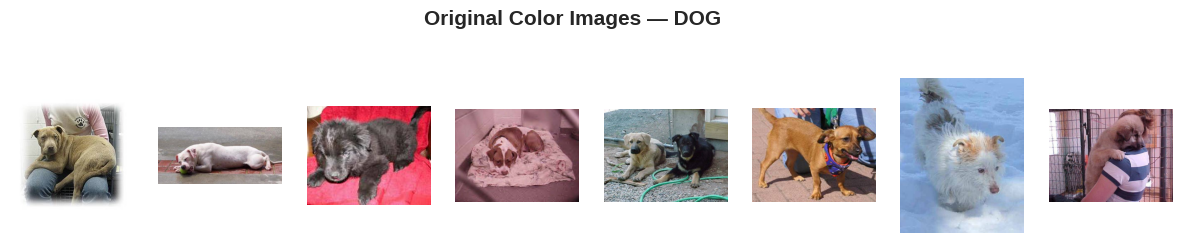

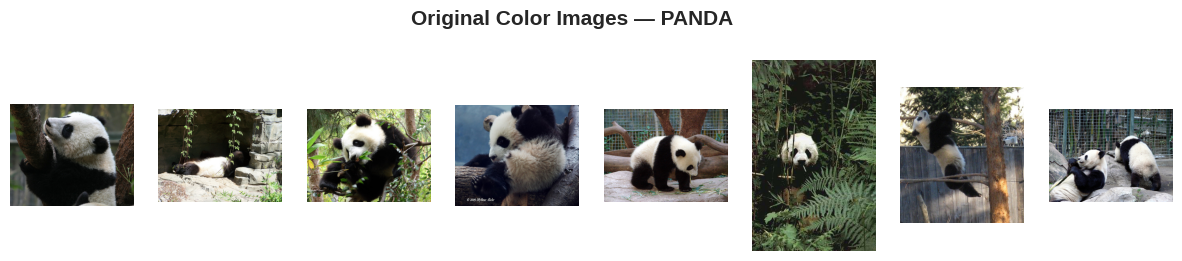

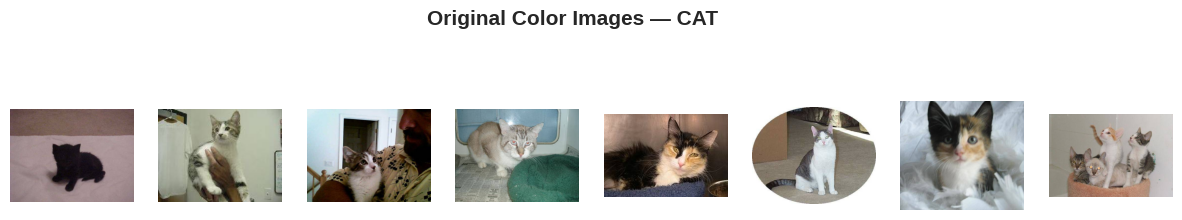

In [35]:
# Visualize Original Color Images

for category in CATEGORIES:
    folder = os.path.join(data_dir, category)
    image_files = os.listdir(folder)[:8]

    fig, axes = plt.subplots(1, 8, figsize=(15, 3))
    fig.suptitle(f"Original Color Images — {category.upper()}", 
                 fontsize=15, fontweight='bold')

    for ax, img_file in zip(axes, image_files):
        img_path = os.path.join(folder, img_file)
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()


In [8]:
# Load and Preprocess Images to Grayscale
IMG_SIZE = 32
TRAIN_DATA = []

for category in CATEGORIES:
    path = os.path.join(data_dir, category)
    class_num = CATEGORIES.index(category)
    class_count = 0

    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        TRAIN_DATA.append([img_gray, class_num])
        class_count += 1

    print(f"✓ {category}: Loaded {class_count} images")

print(f"\n✓ Total images loaded: {len(TRAIN_DATA)}")
print(f"   Image size: {IMG_SIZE} x {IMG_SIZE} pixels (grayscale)")

✓ dog: Loaded 100 images
✓ panda: Loaded 100 images
✓ cat: Loaded 100 images

✓ Total images loaded: 300
   Image size: 32 x 32 pixels (grayscale)


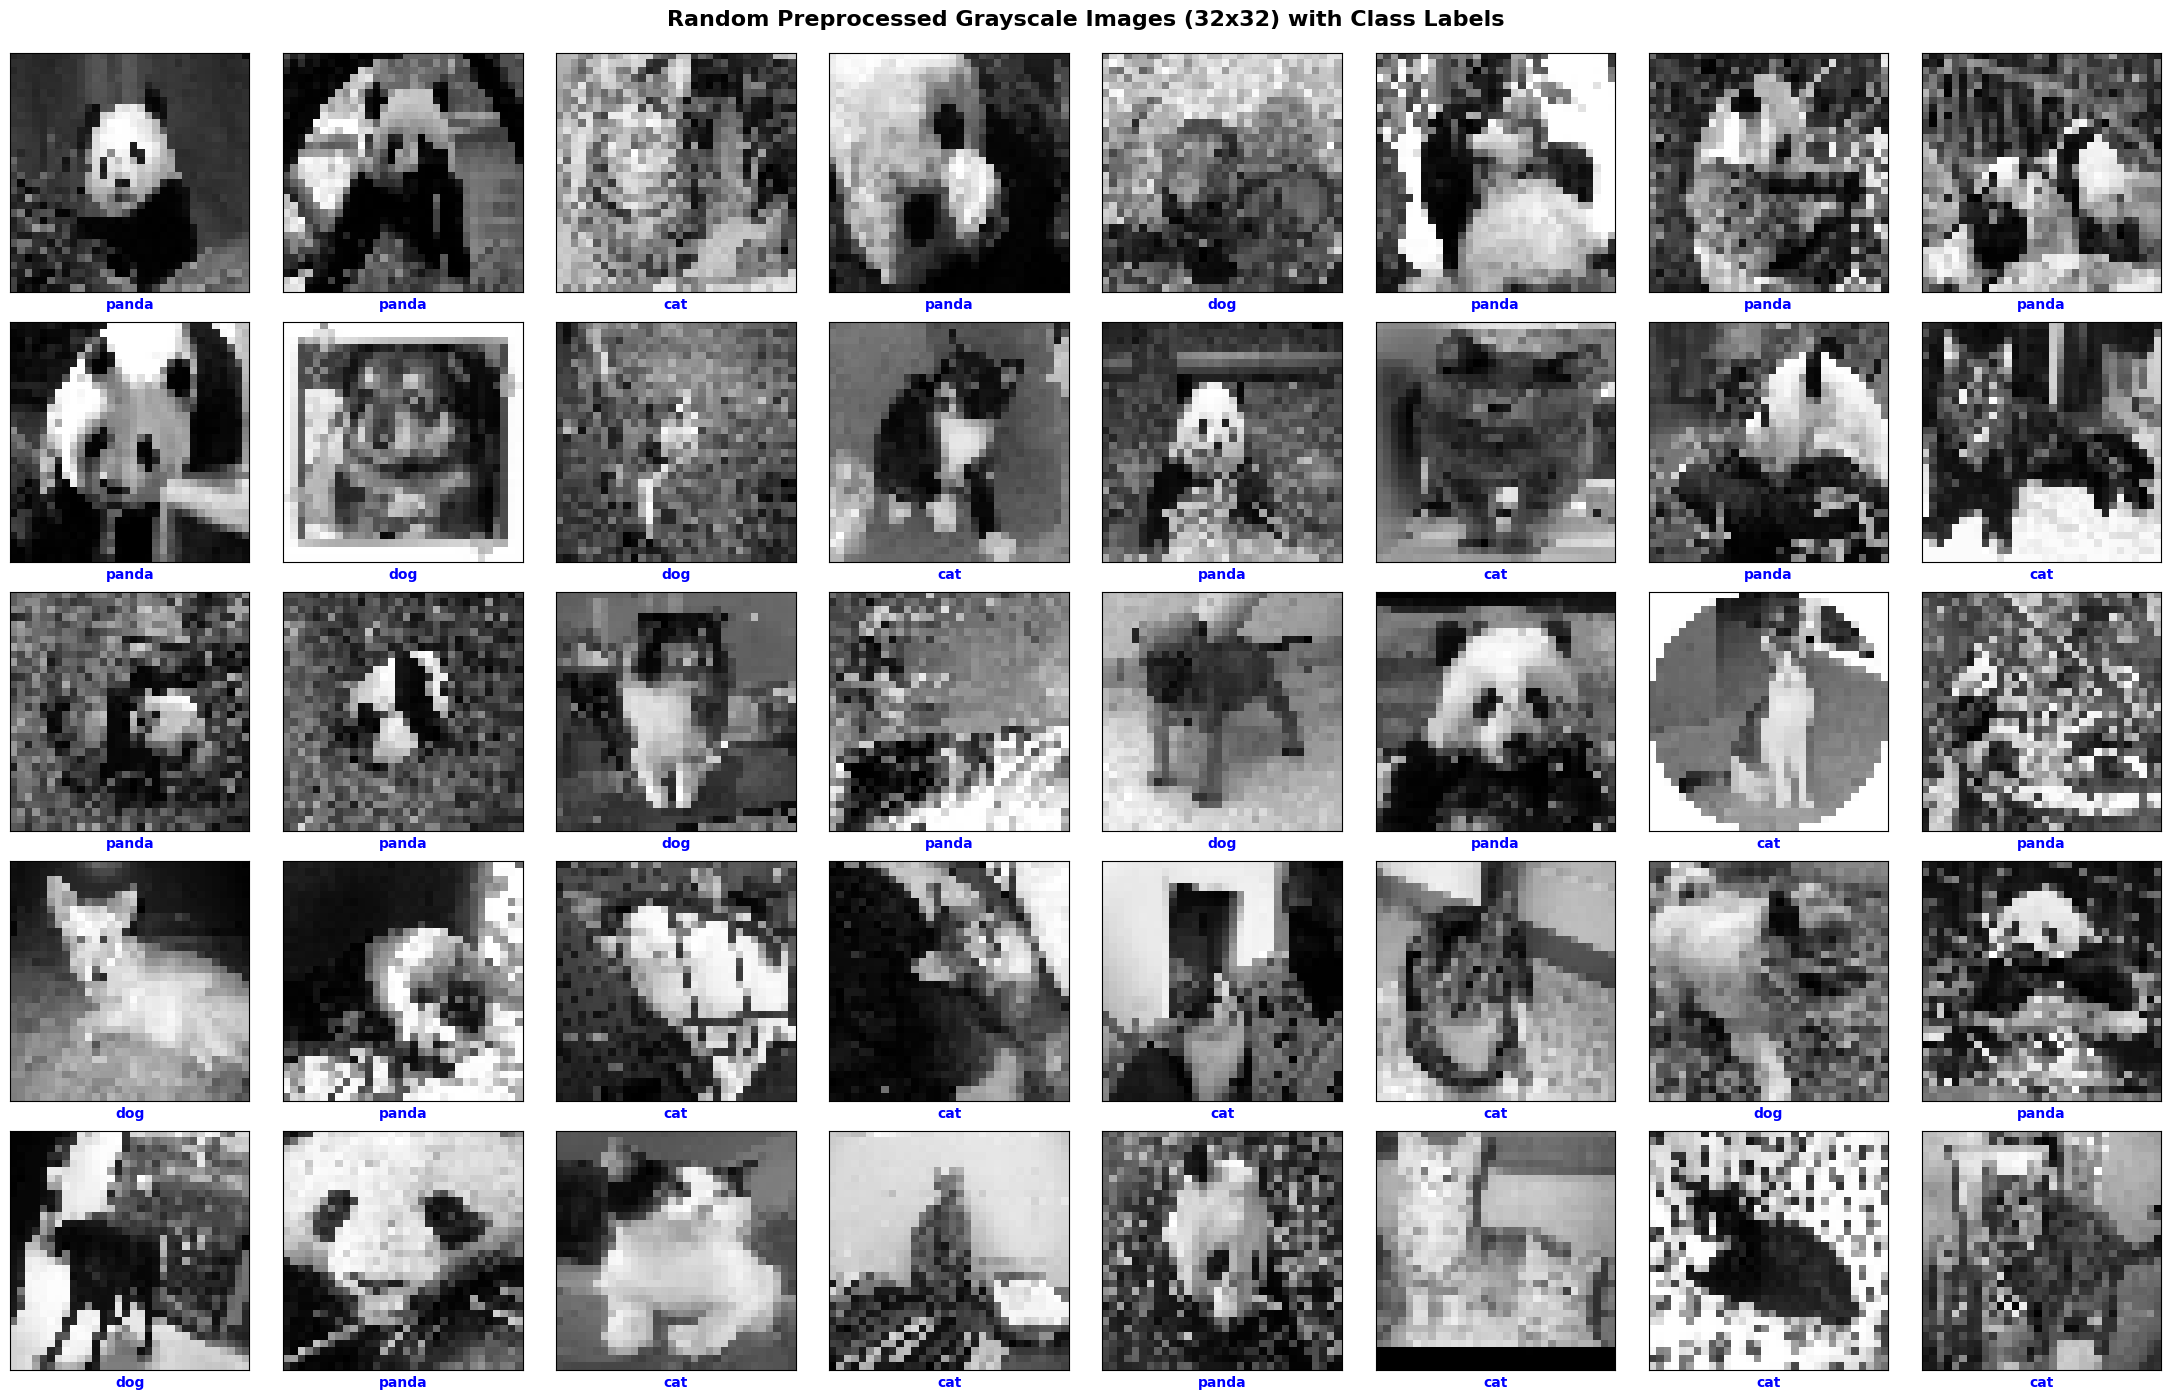

In [10]:
# Visualize Sample Grayscale Images

fig = plt.figure(figsize=(22, 14))
random_indices = random.sample(range(len(TRAIN_DATA)), 40)

for i, idx in enumerate(random_indices):
    plt.subplot(5, 8, i + 1)
    gray_img, label = TRAIN_DATA[idx]
    class_name = CATEGORIES[label]
    
    plt.imshow(gray_img, cmap="gray")
    plt.xlabel(class_name, fontsize=10, fontweight='bold', color='blue')
    plt.xticks([])
    plt.yticks([])

fig.suptitle("Random Preprocessed Grayscale Images (32x32) with Class Labels",
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [11]:
# Prepare Features and Labels

features = []
labels = []

for img, label in TRAIN_DATA:
    img_flat = img.flatten().astype(np.float32) / 255.0
    features.append(img_flat)
    labels.append(label)

features = np.array(features)
labels = np.array(labels)

print(f"\n✓ Features shape: {features.shape}")
print(f"✓ Labels shape: {labels.shape}")
print(f"✓ Feature range: [{features.min():.3f}, {features.max():.3f}]")
print(f"✓ Unique classes: {np.unique(labels)}")


✓ Features shape: (300, 1024)
✓ Labels shape: (300,)
✓ Feature range: [0.000, 1.000]
✓ Unique classes: [0 1 2]


In [12]:
# Shuffle and Create 5-Fold Splits

# Combine and shuffle
data = list(zip(features, labels))
random.shuffle(data)

# Create 5 folds
n_folds = 5
fold_size = len(data) // n_folds
folds = [data[i * fold_size : (i + 1) * fold_size] for i in range(n_folds)]

# Handle remainder
remainder = len(data) % n_folds
for i in range(remainder):
    folds[i].append(data[n_folds * fold_size + i])

print("\n✓ Fold sizes:")
for i, fold in enumerate(folds):
    print(f"   Fold {i+1}: {len(fold)} samples")


✓ Fold sizes:
   Fold 1: 60 samples
   Fold 2: 60 samples
   Fold 3: 60 samples
   Fold 4: 60 samples
   Fold 5: 60 samples


In [13]:
# Define Distance Functions

def manhattan_distance(vec1, vec2):
    # Manhattan (L1) distance: Sum of absolute differences
    return np.sum(np.abs(vec1 - vec2))

def euclidean_distance(vec1, vec2):
    # Euclidean (L2) distance: Square root of sum of squared differences
    return np.sqrt(np.sum((vec1 - vec2) ** 2))


# Test distances
d_l1 = manhattan_distance(features[0], features[1])
d_l2 = euclidean_distance(features[0], features[1])
print(f"Test L1 distance: {d_l1:.4f}")
print(f"Test L2 distance: {d_l2:.4f}")

same_image_d1 = manhattan_distance(features[10], features[10])
print(f"Test L1 distance of same feature/image:{same_image_d1:.4f}")

Test L1 distance: 296.4785
Test L2 distance: 10.5689
Test L1 distance of same feature/image:0.0000


In [14]:
# KNN Prediction Function

def knn_predict(X_train, y_train, x_test, k=5, distance_type='l2'):
    distances = []
    
    # Compute distances
    for i in range(len(X_train)):
        if distance_type == 'l1':
            dist = manhattan_distance(X_train[i], x_test)
        else:
            dist = euclidean_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))
    
    # Sort by smallest distance
    distances.sort(key=lambda x: x[0])
    
    # Take top-k labels
    k_labels = [label for _, label in distances[:k]]
    
    # Manual frequency count
    label_count = {}
    for label in k_labels:
        label_count[label] = label_count.get(label, 0) + 1
    
    # Find label with highest count
    most_common = max(label_count, key=label_count.get)
    
    return most_common


In [36]:
# 5-Fold Cross-Validation

def run_knn_cross_validation(folds, k_values, distance_type='l2'):
    fold_wise_accuracies = []

    for fold_index in range(len(folds)):
        validation_data = folds[fold_index]
        training_data = []
        for i in range(len(folds)):
            if i != fold_index:
                training_data.extend(folds[i])

        X_train = np.array([item[0] for item in training_data])
        y_train = np.array([item[1] for item in training_data])
        X_val = np.array([item[0] for item in validation_data])
        y_val = np.array([item[1] for item in validation_data])

        fold_accuracies = []

        for k in k_values:
            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[i], k=k, 
                                  distance_type=distance_type)
                if pred == y_val[i]:
                    correct += 1
            accuracy = correct / len(X_val)
            fold_accuracies.append(accuracy)

        fold_wise_accuracies.append(fold_accuracies)
        print(f"✓ Fold {fold_index + 1}/5 completed")

    avg_accuracies = np.mean(fold_wise_accuracies, axis=0)
    return fold_wise_accuracies, avg_accuracies

# Define K values
K_values = np.arange(3, 26, 2)

print(f"K values to test: {list(K_values)}")
print("--- Manhattan (L1) Distance ---")
fold_acc_l1, avg_acc_l1 = run_knn_cross_validation(folds, K_values, distance_type='l1')

print("--- Euclidean (L2) Distance ---")
fold_acc_l2, avg_acc_l2 = run_knn_cross_validation(folds, K_values, distance_type='l2')

K values to test: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
--- Manhattan (L1) Distance ---
✓ Fold 1/5 completed
✓ Fold 2/5 completed
✓ Fold 3/5 completed
✓ Fold 4/5 completed
✓ Fold 5/5 completed
--- Euclidean (L2) Distance ---
✓ Fold 1/5 completed
✓ Fold 2/5 completed
✓ Fold 3/5 completed
✓ Fold 4/5 completed
✓ Fold 5/5 completed


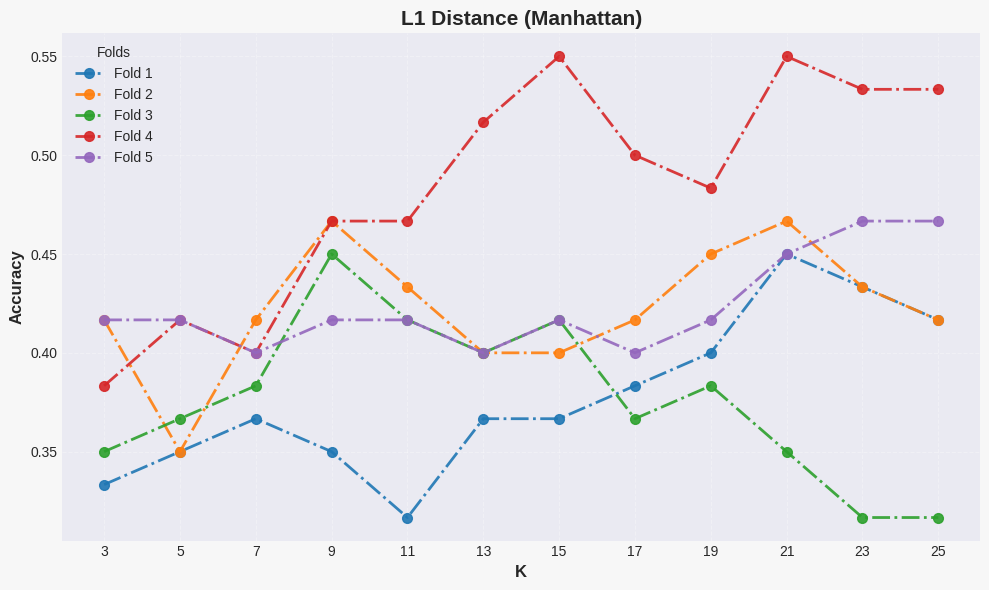

In [37]:
fold_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']


fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("#f7f7f7")  

for i, acc in enumerate(fold_acc_l1):
    ax.plot(K_values, acc, marker='o', linestyle='-.', 
            color=fold_colors[i], linewidth=2, markersize=7,
            label=f'Fold {i+1}', alpha=0.9)

ax.set_xlabel('K', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('L1 Distance (Manhattan)', fontsize=15, fontweight='bold')
ax.set_xticks(K_values)

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(title="Folds", fontsize=10)
plt.tight_layout()
plt.show()

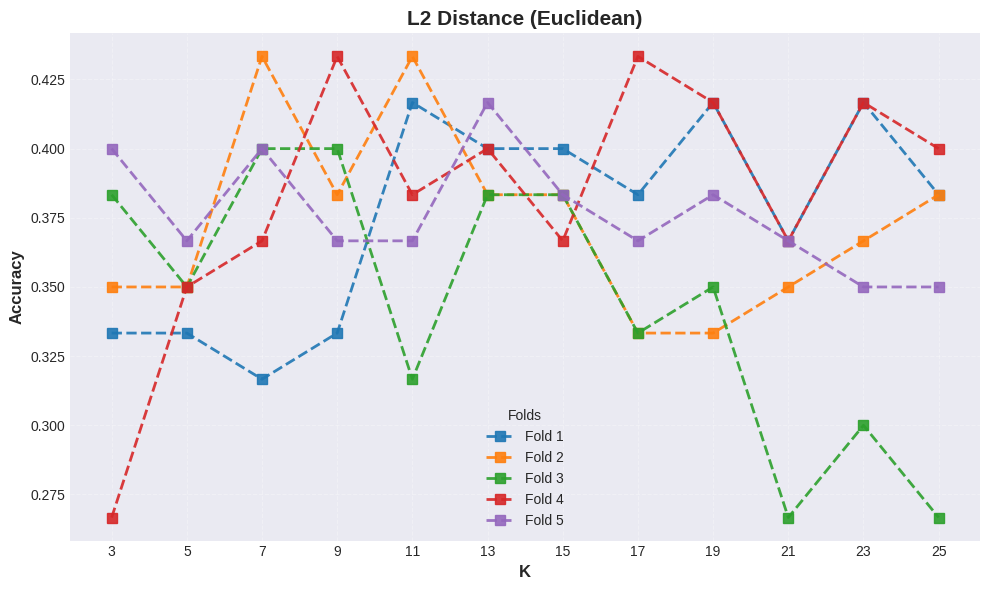

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, acc in enumerate(fold_acc_l2):
    ax.plot(K_values, acc, marker='s', linestyle='--', 
            color=fold_colors[i], linewidth=2, markersize=7,
            label=f'Fold {i+1}', alpha=0.9)

ax.set_xlabel('K', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('L2 Distance (Euclidean)', fontsize=15, fontweight='bold')
ax.set_xticks(K_values)

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(title="Folds", fontsize=10)
plt.tight_layout()
plt.show()

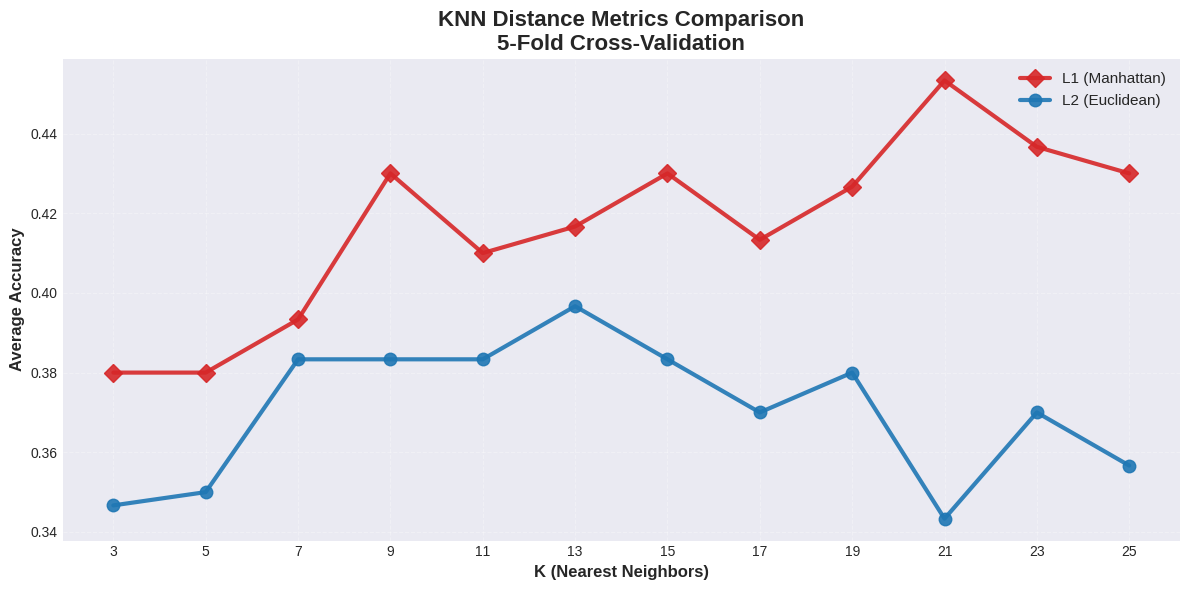

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(K_values, avg_acc_l1, marker='D', linestyle='-', 
        linewidth=3, markersize=9, color="#d62728", 
        label='L1 (Manhattan)', alpha=0.9)

ax.plot(K_values, avg_acc_l2, marker='o', linestyle='-', 
        linewidth=3, markersize=9, color="#1f77b4",
        label='L2 (Euclidean)', alpha=0.9)

ax.set_xlabel('K (Nearest Neighbors)', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Accuracy', fontsize=12, fontweight='bold')
ax.set_title('KNN Distance Metrics Comparison\n5-Fold Cross-Validation',
             fontsize=16, fontweight='bold')
ax.set_xticks(K_values)

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()


In [40]:
print("=== Accuracy Summary by K Value ===")

print("L1 (Manhattan) Accuracy:")
for k, acc in zip(K_values, avg_acc_l1):
    print(f"  • K = {k:2d} → {acc*100:.2f}%")

print("L2 (Euclidean) Accuracy:")
for k, acc in zip(K_values, avg_acc_l2):
    print(f"  • K = {k:2d} → {acc*100:.2f}%")


best_k_l1 = K_values[np.argmax(avg_acc_l1)]
best_acc_l1 = max(avg_acc_l1)
best_k_l2 = K_values[np.argmax(avg_acc_l2)]
best_acc_l2 = max(avg_acc_l2)

print("=== Best Performance ===")

print(f"• Manhattan (L1):")
print(f"    Best K         : {best_k_l1}")
print(f"    Best Accuracy  : {best_acc_l1*100:.2f}%")

print(f"\n• Euclidean (L2):")
print(f"    Best K         : {best_k_l2}")
print(f"    Best Accuracy  : {best_acc_l2*100:.2f}%")


if best_acc_l2 > best_acc_l1:
    winner = "Euclidean (L2)"
    diff = (best_acc_l2 - best_acc_l1) * 100
else:
    winner = "Manhattan (L1)"
    diff = (best_acc_l1 - best_acc_l2) * 100

print("\n=== Final Comparison ===")
print(f"✓ Winner: {winner}")
print(f"✓ Performance Difference: {diff:.2f}%\n")

=== Accuracy Summary by K Value ===
L1 (Manhattan) Accuracy:
  • K =  3 → 38.00%
  • K =  5 → 38.00%
  • K =  7 → 39.33%
  • K =  9 → 43.00%
  • K = 11 → 41.00%
  • K = 13 → 41.67%
  • K = 15 → 43.00%
  • K = 17 → 41.33%
  • K = 19 → 42.67%
  • K = 21 → 45.33%
  • K = 23 → 43.67%
  • K = 25 → 43.00%
L2 (Euclidean) Accuracy:
  • K =  3 → 34.67%
  • K =  5 → 35.00%
  • K =  7 → 38.33%
  • K =  9 → 38.33%
  • K = 11 → 38.33%
  • K = 13 → 39.67%
  • K = 15 → 38.33%
  • K = 17 → 37.00%
  • K = 19 → 38.00%
  • K = 21 → 34.33%
  • K = 23 → 37.00%
  • K = 25 → 35.67%
=== Best Performance ===
• Manhattan (L1):
    Best K         : 21
    Best Accuracy  : 45.33%

• Euclidean (L2):
    Best K         : 13
    Best Accuracy  : 39.67%

=== Final Comparison ===
✓ Winner: Manhattan (L1)
✓ Performance Difference: 5.67%



## 📌 Discussion: KNN Distance Metric Comparison (L1 vs L2)

The graph shows how **Manhattan (L1)** and **Euclidean (L2)** distances perform across different **odd K values (3–25)** during 5-fold cross-validation.

### ✅ Key Observations
- **L1 distance consistently performs better** than L2 across almost all K values.
- The **highest accuracy for L1** occurs around **K = 21**, where it peaks the most.
- L2 shows a smoother but generally **lower performance**, with small improvements near K = 13 and 23.
- **Small K (3–7)** yields lower accuracy for both metrics, indicating sensitivity to noise.
- **Mid-range K values (9–21)** give the best stability and overall performance.

### 💡 Interpretation
- L1 may fit this dataset better because it is **less sensitive to large pixel differences**, making it more robust for noisy or uneven grayscale images.
- L2, which squares differences, may amplify pixel-level variations, resulting in slightly weaker classification performance.

### 🎯 Conclusion
**Manhattan (L1) distance is the better choice** for this dataset, showing higher and more stable accuracy across K values.



Using: L1 distance with K=21
(Best performing configuration from cross-validation)



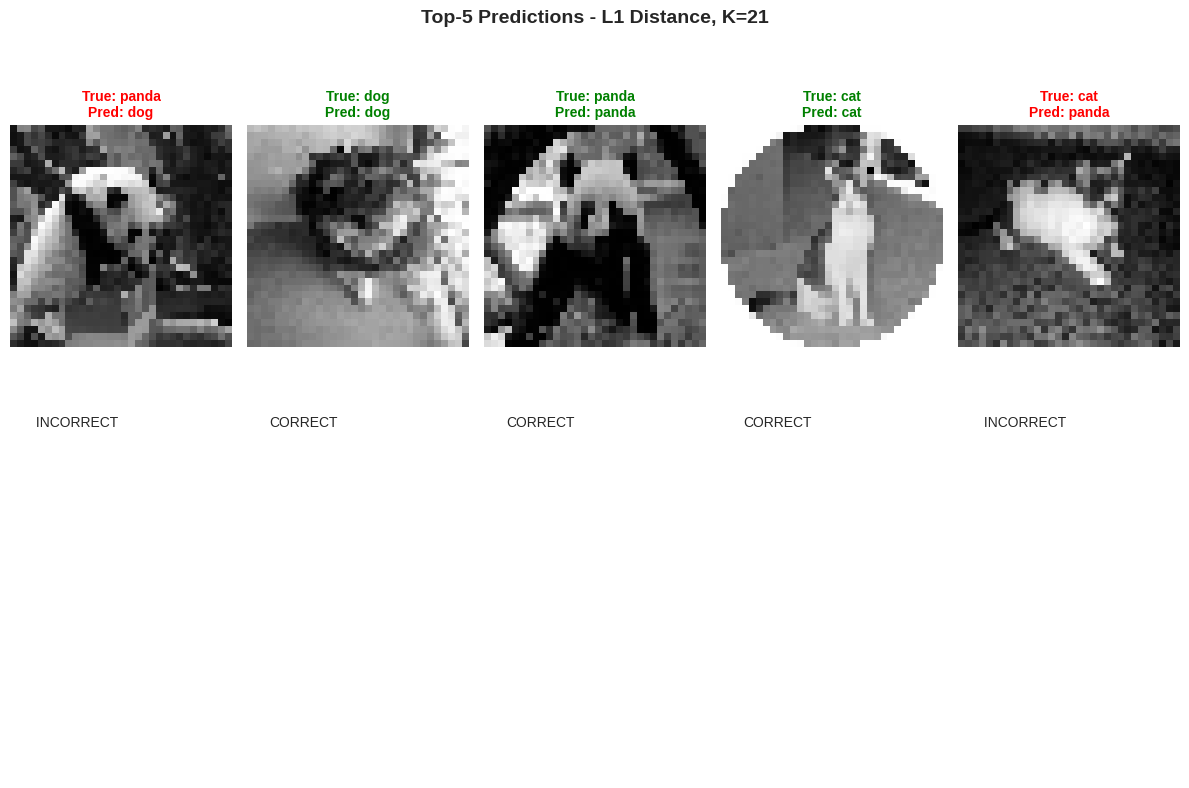

Predictions displayed!
Correct: 3/5
Accuracy: 60.00%


In [41]:
# Top-5 Predictions Display

# Use best configuration
best_metric = 'l2' if best_acc_l2 > best_acc_l1 else 'l1'
best_k = best_k_l2 if best_acc_l2 > best_acc_l1 else best_k_l1

print(f"\nUsing: {best_metric.upper()} distance with K={best_k}")
print("(Best performing configuration from cross-validation)\n")

# Use first fold as test, rest as train
test_data = folds[0]
train_data = []
for i in range(1, 5):
    train_data.extend(folds[i])

X_train = np.array([item[0] for item in train_data])
y_train = np.array([item[1] for item in train_data])

num_test = 5
fig, axes = plt.subplots(2, num_test, figsize=(12, 8))

correct_count = 0

for idx in range(num_test):
    x_test, y_true = test_data[idx]
    
    # Make prediction
    y_pred = knn_predict(X_train, y_train, x_test, k=best_k, 
                        distance_type=best_metric)
    
    is_correct = (y_pred == y_true)
    if is_correct:
        correct_count += 1
    
    # Display test image
    ax_img = axes[0, idx]
    img_display = x_test.reshape(IMG_SIZE, IMG_SIZE)
    ax_img.imshow(img_display, cmap='gray')
    ax_img.axis('off')
    
    # Border color
    border_color = 'green' if is_correct else 'red'
    for spine in ax_img.spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(3)
    
    title = f"True: {CATEGORIES[y_true]}\nPred: {CATEGORIES[y_pred]}"
    ax_img.set_title(title, fontsize=10, fontweight='bold', 
                    color=border_color)
    
    # Display prediction info
    ax_text = axes[1, idx]
    ax_text.axis('off')

    info_text = ""
    
    info_text += f"{'CORRECT' if is_correct else ' INCORRECT'}"
    
    ax_text.text(0.1, 0.9, info_text)

fig.suptitle(f'Top-5 Predictions - {best_metric.upper()} Distance, K={best_k}',
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Predictions displayed!")
print(f"Correct: {correct_count}/{num_test}")
print(f"Accuracy: {correct_count/num_test*100:.2f}%")